In [568]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [569]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json

%matplotlib inline

In [570]:
# GPU 메모리 사용량 증가 설정
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)


In [571]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

In [572]:
model=load_model('../models/affectnet_emotions/mobilenet_7.h5')
model.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_pad (ZeroPadding2D)       │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,493,063 (13.32 MB)

 Trainable params: 3,471,175 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [573]:
def mobilenet_preprocess_input(x,**kwargs):
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x
preprocessing_function=mobilenet_preprocess_input
INPUT_SIZE = (224, 224)

In [574]:
# Code borrowed from https://keras.io/examples/vision/grad_cam/
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(face_img, alpha=0.4):
    last_conv_layer_name = "conv_pw_13"
    inp=face_img.astype(np.float32)
    inp=preprocessing_function(inp)
    inp = np.expand_dims(inp, axis=0)
    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    scores = model.predict(inp)[0]

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(inp, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((face_img.shape[1], face_img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + face_img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    #superimposed_img.save(cam_path)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.title(idx_to_class[np.argmax(scores)])
    plt.imshow(superimposed_img)

In [575]:
#감정 라벨
data_classes={'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Neutral': 4, 'Sadness': 5, 'Surprise': 6}
idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

# 정답 레이블
ans = []
# 예측 레이블
pred = []

In [576]:
# picture 폴더 경로
picture_dir='./occidental_picture/all/'

# 결과 저장할 폴더
save_dir = "./grad-cam_picture/occidental/fear/"

In [ ]:
#파일경로에 있는 jpg파일을 순서대로 읽어들여 감정을 추측하고 정답과 예측 레이블 생성하는 코드

for fname in os.listdir(picture_dir):
    if fname.endswith('.jpg'):
        fpath = os.path.join(picture_dir, fname)
        fpath = fpath.encode('utf-8').decode('utf-8')

        frame_bgr=cv2.imread(fpath)
        if frame_bgr is None:
            print(f"Error loading image: {fpath}")
            continue

        # plt.figure(figsize=(5, 5))
        # plt.axis('off')
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame)

        bounding_boxes, points = imgProcessing.detect_faces(frame)
        points = points.T
        if len(bounding_boxes) > 0:
            box = bounding_boxes[0].astype(int)
            x1,y1,x2,y2=box[0:4]   

            if x2 > x1 and y2 > y1:
                face_img = frame[y1:y2, x1:x2, :]
                if face_img.size == 0:
                    print(f"얼굴 크기 오류: {fname} (x1={x1}, y1={y1}, x2={x2}, y2={y2})")
                    continue 
            
                face_img=cv2.resize(face_img,INPUT_SIZE)
                inp=face_img.astype(np.float32)
                inp[..., 0] -= 103.939
                inp[..., 1] -= 116.779
                inp[..., 2] -= 123.68
                inp = np.expand_dims(inp, axis=0)

                scores=model.predict(inp)[0] #모델로 감정 예측
                predicted_label = np.argmax(scores)
                pred.append(predicted_label) #가장 높은 확률의 클래스를 예측 레이블에에 저장

                # plt.figure(figsize=(3, 3))
                # plt.axis('off')
                # plt.imshow(face_img)
                # plt.title(idx_to_class[predicted_label])

                # 파일명으로부터 정답레이블 생성
                emotion = fname.split('_')[1]
                print(emotion)
                if emotion in data_classes:
                    ans.append(data_classes[emotion])
                    correct_label = data_classes[emotion]
                else:
                    continue
                
                # 정답과 예측이 일치할 때만 저장
                if predicted_label == correct_label:
                    plt.figure(figsize=(3, 3))
                    save_and_display_gradcam(face_img)
                    save_path = os.path.join(save_dir, f"gradcam_{fname}")  # 저장 파일 경로
                    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)  # JPG 저장
                    plt.close()  # 창 닫기
                
            else:
                print(f"잘못된 bounding box 좌표: {fname}")
        else:
            print(f"얼굴을 감지하지 못했습니다.: {fname}")

print("정답 레이블:", ans)
print("예측 레이블:", pred)

Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Sadness
1/1 ━━━━━━━━━━━━━━━━━━━

In [578]:
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(ans, pred)

# 정확도 계산 (TP + TN) / (TP + TN + FP + FN)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.59


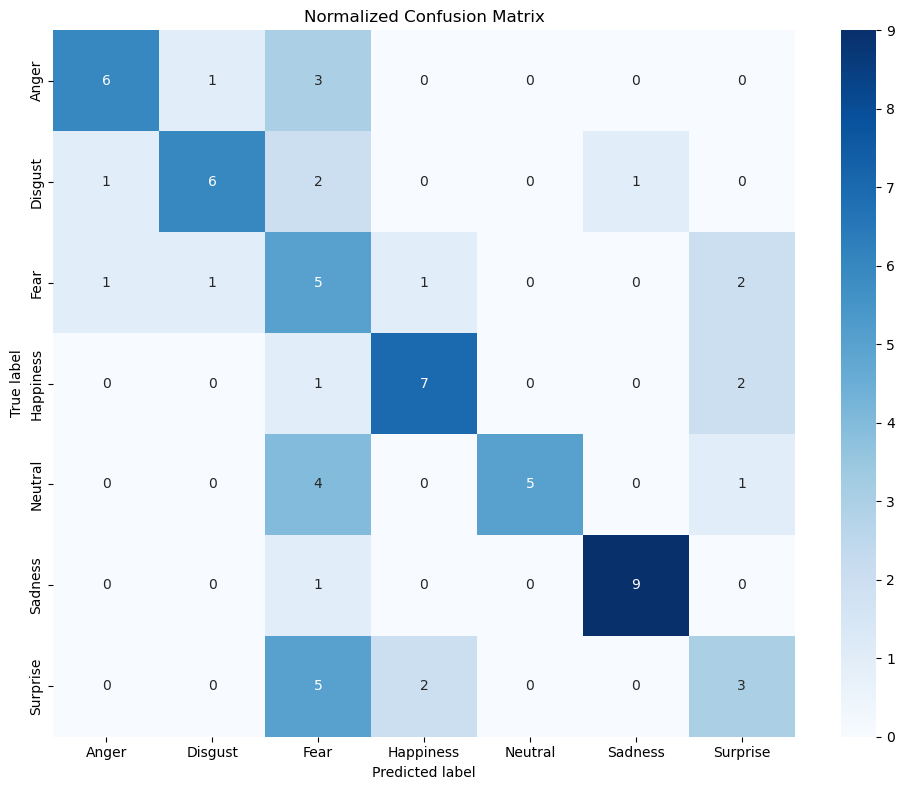

In [579]:
# Confusion Matrix 출력

import seaborn as sns
from sklearn.metrics import confusion_matrix


idx_to_class = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

cm = confusion_matrix(ans, pred) #Confusion Matrix 계산

class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
